In [8]:
import json
import os
import pickle
from itertools import product
from typing import Dict, Any, List
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import numpy as np
import tqdm
from sklearn.preprocessing import StandardScaler
from ruzicka.BDIVerifier import BDIVerifier

from tools.prepare import extract_all_authors_decade, QueryCandidatesImpostors
from tools.constants import rng
from tools import compress


authors = pd.read_pickle("authors.pickle")

metadata_cols = [col for col in authors.columns if col.startswith("var_")]
authors = authors[metadata_cols].reset_index()
authors = authors.drop_duplicates("var_title")



def count_gap(years, df):
    data = []
    for _, row in df.iterrows():
        data.append(df[(df.var_author == row.var_author) & (df.var_date >= (row.var_date+years))].shape[0])
    return data
    
def count_gap_neg(years, df):
    data = []
    for _, row in df.iterrows():
        data.append(df[(df.var_author == row.var_author) & (df.var_date <= (row.var_date-years))].shape[0])
    return data
    
authors["1"] = count_gap(1, authors)
authors["5"] = count_gap(5, authors)
authors["10"] = count_gap(10, authors)
authors["15"] = count_gap(15, authors)
authors["-1"] = count_gap_neg(1, authors)
authors["-5"] = count_gap_neg(5, authors)
authors["-10"] = count_gap_neg(10, authors)
authors["-15"] = count_gap_neg(15, authors)
authors = authors.drop_duplicates(("var_author", "var_date"))
authors["relative_year"] = authors.groupby("var_author")["var_date"].transform(lambda x: x - x.min())
authors["var_author"] = authors["var_author"].apply(lambda x: x.title())
authors = authors.sort_values("var_author")
authors

,var_title,var_author,var_date,var_window,1,5,10,15,-1,-5,-10,-15,relative_year
9089,envers-histoire-contemporaine,Balzac,1848,[0.0:0],0,0,0,0,80,72,51,32,19
8712,muse-departement,Balzac,1843,[0.0:0],9,1,0,0,69,51,32,0,14
7986,seraphita,Balzac,1834,[0.0:0],42,30,9,0,32,2,0,0,5
8006,louis-lambert,Balzac,1832,[0.0:0],55,36,16,3,20,0,0,0,3
8041,pierre-grassou,Balzac,1839,[0.0:0],23,9,0,0,51,39,2,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,germinal,Zola,1885,[0.0:0],7,4,0,0,12,9,5,0,14
976,argent,Zola,1891,[0.0:0],2,0,0,0,17,14,9,6,20
1036,ventre-paris,Zola,1873,[0.0:0],17,14,10,5,2,0,0,0,2
533,terre,Zola,1887,[0.0:0],5,2,0,0,14,10,6,2,16


In [9]:
authors[authors.var_author=="zola"]['1 	5 	10 	15 	-1 	-5 	-10 	-15'.split() + ["var_date"]].sort_values("var_date")

,1,5,10,15,-1,-5,-10,-15,var_date


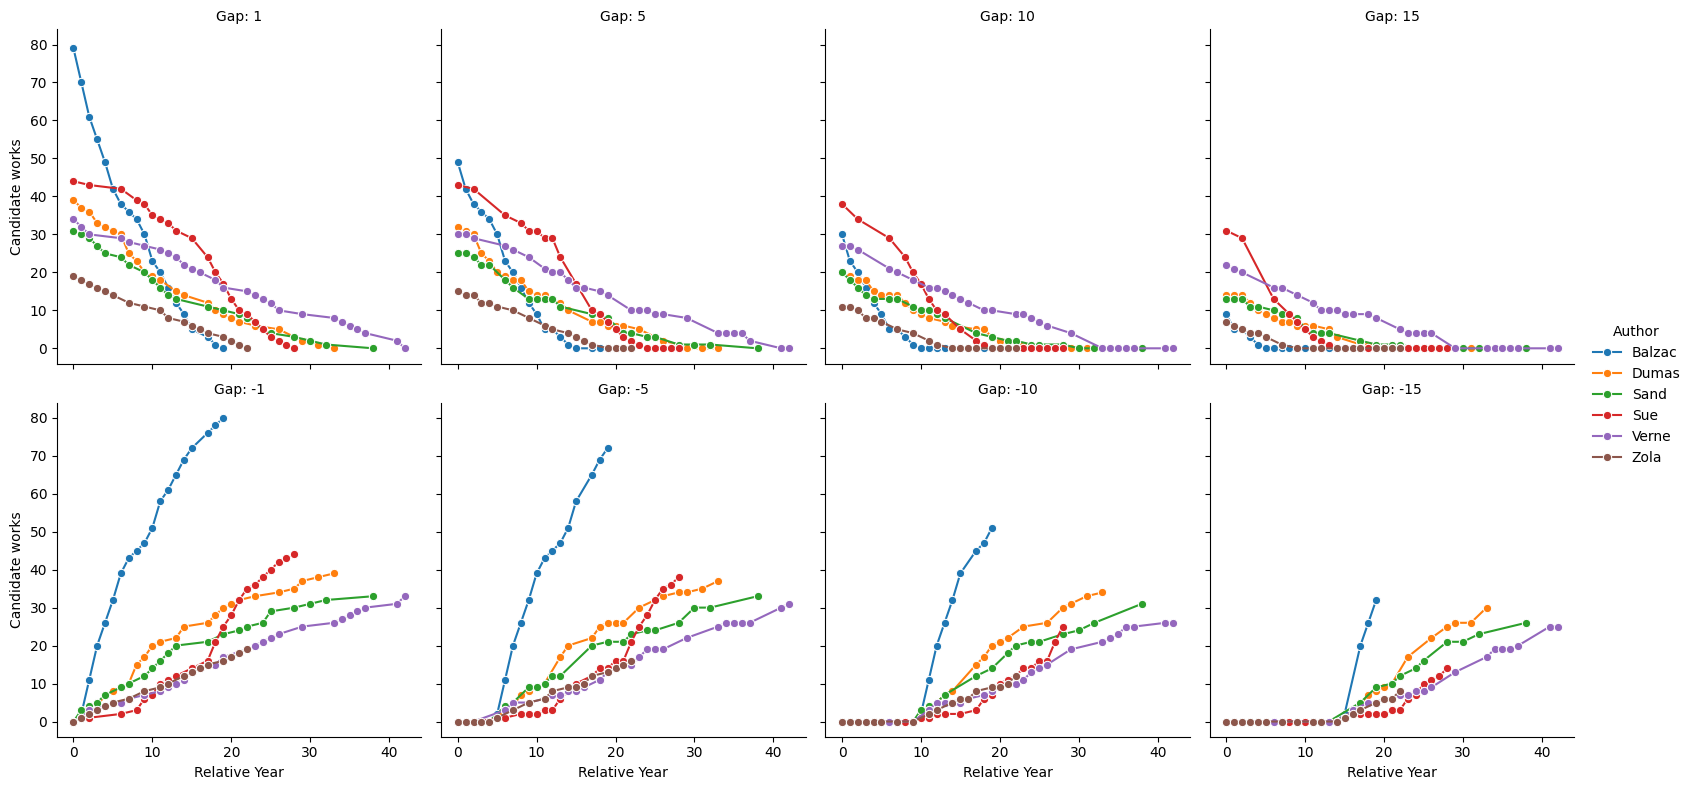

In [10]:
import seaborn as sns

import matplotlib.pyplot as plt

# Reshape the DataFrame: from wide to long format
long_df = authors.melt(
    id_vars=["relative_year", "var_author"],
    value_vars=["1", "5", "10", "15", "-1", "-5", "-10", "-15"],
    var_name="gap_type",
    value_name="count"
)
long_df
# Create facet grid by gap_type
g = sns.FacetGrid(long_df, col="gap_type", col_wrap=4, height=4, sharey=True)

# Draw a lineplot per facet with authors as hue
g.map_dataframe(
    sns.lineplot,
    x="relative_year",
    y="count",
    hue="var_author",
    marker="o"
)

# Add legend and tidy up
g.add_legend(title="Author")
g.set_axis_labels("Relative Year", "Candidate works")
g.set_titles("Gap: {col_name}")
# plt.tight_layout()
plt.savefig("support.png", dpi=300, bbox_inches='tight')
plt.show()
